In [2]:
import findspark
findspark.init()

import json
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_utc_timestamp, from_unixtime, to_date, sum,count, mean, countDistinct, max,first
from pyspark import SparkContext
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.types import IntegerType,StructField,StructType, LongType, FloatType
from pyspark.sql.functions import col, when

from pyspark.sql.functions import monotonically_increasing_id, coalesce, date_trunc, regexp_extract
import snap
from os import path
import glob

import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from bitcoin_utils import bitcoin_utils
import plotly
import plotly.express as px
pd.options.plotting.backend = "plotly"
import plotly.io as pio


In [3]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.cores.max", "10") \
    .getOrCreate()
sc = spark.sparkContext

In [16]:
def write_formated_plot(fig,location,legend=False):
    fig.layout.update(showlegend=legend)
    fig.update_layout(
    margin=dict(l=10, r=10, t=5, b=5))
    #fig.update_traces(mode="lines", hovertemplate=None)
    fig.update_layout(hovermode="x unified")
    pio.write_html(fig, file=location, include_mathjax=False,include_plotlyjs=False,full_html=False)
    return fig

In [5]:
output_dir = "/home/remy/bitcoin-cleaning/charts/"

In [179]:
data= spark.read.load("/media/ssd2/bitcoinRemy/tr_everything_by_day/")

In [195]:
data.agg(sum("value")/100000000,
         count("value"),
         countDistinct("hash"),
         count(when(col("src")=="mining","count")),
         (sum(when(col("src")=="mining",col("value")))/100000000)
        ).show()

+------------------+------------+-----------+
|        sum(value)|count(value)|count(hash)|
+------------------+------------+-----------+
|604875346287703123|  1636976987|  609437067|
+------------------+------------+-----------+



In [103]:
test = get_monthly_stat(data.filter(col("year")==2010))

In [104]:
test

,year,month,#transactions,#mining,sum_btc,#outputs,sum_dol,mining_btc,mining_dol,#mining_outputs,PriceUSD,#unspent,spending_time
2010-01-01,2010,1,5055,5003,2.938313e+05,5072,NaN,250150.260000,NaN,5003,NaN,1232,10219.813934
2010-02-01,2010,2,5751,5603,5.169752e+05,5783,NaN,280150.440000,NaN,5603,NaN,1226,7417.007010
2010-03-01,2010,3,5384,5187,4.113557e+05,5411,NaN,259350.000000,NaN,5187,NaN,1392,7091.550237
2010-04-01,2010,4,9636,5586,7.426493e+05,12963,NaN,279300.260000,NaN,5586,NaN,1343,2192.793279
2010-05-01,2010,5,6213,4942,7.496488e+05,6375,NaN,247110.340000,NaN,4942,NaN,705,3402.674303
2010-06-01,2010,6,6667,4736,1.087357e+06,7101,NaN,236801.370000,NaN,4736,NaN,686,3288.887688
2010-07-01,2010,7,26491,7878,4.727958e+06,38602,43186.880,393909.520000,0.000087,7878,0.063171,3592,2219.524726
2010-08-01,2010,8,11972,6021,1.496586e+06,15260,95915.653,301060.970001,0.000194,6021,0.064293,2034,2641.014890
2010-09-01,2010,9,13171,5541,1.680795e+06,17443,103821.358,277052.009604,0.000171,5567,0.061865,1507,2755.134823
2010-10-01,2010,10,14405,5902,5.203869e+06,19959,535667.492,295101.003304,0.000337,5942,0.108407,1612,1890.369252


In [95]:
#data.filter(col("src")=="mining").show(truncate=False)

In [183]:
def get_monthly_stat(df,name):
    agg = df.groupBy("year","month").agg(
                                   (sum("value")/100000000).alias("sum_btc_"+name),
                                   count("value").alias("count_"+name),
                                   sum("valueUSD").alias("sum_USD_"+name),
                                    (sum(when(col("src")=="mining",col("value")))/100000000).alias("sum_mining_btc_"+name),
                                    (sum(when(col("src")=="mining",col("valueUSD")))).alias("sum_mining_USD_"+name),
                                    count(when(col("src")=="mining","count")).alias("nb_mining_"+name),
                                   mean("PriceUSD").alias("PriceUSD_"+name),
                                   count(when(col("spent_timestamp").isNull(),"value")).alias("nb_unspent_"+name),
                                   mean((col("spent_timestamp")-col("time"))/60/60).alias("mean_spending_time_"+name),
                (count(when(col("nb_inputs")==1,"a"))).alias("nb_input=1_"+name),
                (count(when((col("nb_inputs")>=2) & (col("nb_inputs")<5),"a"))).alias("nb_input<5_"+name),
                (count(when(col("nb_inputs")>=5 ,"yes"))).alias("nb_input>=5_"+name),
                (count(when(col("nb_outputs")==1 ,"a"))).alias("nb_outputs==1_"+name),
                (count(when(col("nb_outputs")==2 ,"a"))).alias("nb_outputs==2_"+name),
                (count(when((col("nb_outputs")>=3) & (col("nb_outputs")<5) ,"a"))).alias("nb_outputs<5_"+name),
                (count(when(col("nb_outputs")>=5 ,"a"))).alias("nb_outputs>=5_"+name),
                (count(when(col("src")=="mining","a"))).alias("nb_mining_"+name),
                    (sum(when(col("nb_inputs")==1,col("value")))).alias("sum_input=1_"+name),
                (sum(when((col("nb_inputs")>=2) & (col("nb_inputs")<5),col("value")))).alias("sum_input<5_"+name),
                (sum(when(col("nb_inputs")>=5 ,col("value")))).alias("sum_input>=5_"+name),
                (sum(when(col("nb_outputs")==1 ,col("value")))).alias("sum_outputs==1_"+name),
                (sum(when(col("nb_outputs")==2 ,col("value")))).alias("sum_outputs==2_"+name),
                (sum(when((col("nb_outputs")>=3) & (col("nb_outputs")<5) ,col("value")))).alias("sum_outputs<5_"+name),
                (sum(when(col("nb_outputs")>=5 ,col("value")))).alias("sum_outputs>=5_"+name),
                (sum(when(col("src")=="mining",col("value")))).alias("sum_mining_"+name))
    to_return= agg.select("*").toPandas()
    to_return = to_return.set_index(pd.to_datetime(to_return['year'].astype(str)  + to_return['month'].astype(str), format='%Y%m'))
    to_return = to_return.sort_index()
    return to_return

In [184]:
monthly = get_monthly_stat(data,"output")

In [165]:
monthly.to_csv(output_dir+"monthly_stats")

In [161]:
subset=monthly[["sum_mining","sum_input=1","sum_input<5","sum_input>=5"]]
subset=subset.div(subset.sum(axis=1), axis=0)
fig =subset.plot.area()
fig=write_formated_plot(fig,output_dir+"distribution_nb_inputs_output.html")
#fig.show()



In [252]:
fig =monthly[["nb_transactions","nb_outputs"]].plot.line()
fig=write_formated_plot(fig,output_dir+"nb_transactionsAndOutputs.html")
#fig.show()

In [58]:
for name in ["nb_transactions","nb_outputs","sum_btc","sum_USD","mining_btc","nb_mining_outputs","PriceUSD","nb_unspent","spending_time"]:
    fig =monthly[[name]].plot.line()
    fig=write_formated_plot(fig,output_dir+name+".html")
    #fig.show()

In [171]:
def get_tr_stats(df,name):
    agg = df.groupBy("hash").agg(sum("value").alias("value"),
                                 sum("valueUSD").alias("valueUSD"),
                                 mean("nb_inputs").alias("nb_inputs"),
                                 mean("nb_outputs").alias("nb_outputs"),
                                 first("src").alias("src"),
                                 first("src_identity").alias("src_identity"),
                                 first("src_cat").alias("src_cat"),
                                 mean("fee").alias("fee"),
                                 first("year").alias("year"),
                                 first("month").alias("month"),
                                 first("PriceUSD").alias("PriceUSD")
                                )\
    .withColumn("fee_for100",(col("fee")/(col("value")+col("fee")+1))*100)\
    .withColumn("feeUSD",col("fee")/100000000*col("PriceUSD"))\
    .groupBy("year","month").agg((sum("fee")/100000000).alias("sum_fee_btc_"+name),
                                 sum("value").alias("value_"+name),
                                 mean("fee").alias("mean_fee_satoshi_"+name),
                                 mean("feeUSD").alias("mean_feeUSD_"+name),
                                 mean("fee_for100").alias("mean_fee_for100_"+name),
                                 count("value").alias("count"+name),
                                 mean("nb_inputs").alias("mean_nb_inputs_"+name),
                (count(when(col("nb_inputs")==1,"a"))).alias("nb_input=1_"+name),
                (count(when((col("nb_inputs")>=2) & (col("nb_inputs")<5),"a"))).alias("nb_input<5_"+name),
                (count(when(col("nb_inputs")>=5 ,"yes"))).alias("nb_input>=5_"+name),
                (count(when(col("nb_outputs")==1 ,"a"))).alias("nb_outputs==1_"+name),
                (count(when(col("nb_outputs")==2 ,"a"))).alias("nb_outputs==2_"+name),
                (count(when((col("nb_outputs")>=3) & (col("nb_outputs")<5) ,"a"))).alias("nb_outputs<5_"+name),
                (count(when(col("nb_outputs")>=5 ,"a"))).alias("nb_outputs>=5_"+name),
                (count(when(col("src")=="mining","a"))).alias("nb_mining_"+name),
                    (sum(when(col("nb_inputs")==1,col("value")))).alias("sum_input=1_"+name),
                (sum(when((col("nb_inputs")>=2) & (col("nb_inputs")<5),col("value")))).alias("sum_input<5_"+name),
                (sum(when(col("nb_inputs")>=5 ,col("value")))).alias("sum_input>=5_"+name),
                (sum(when(col("nb_outputs")==1 ,col("value")))).alias("sum_outputs==1_"+name),
                (sum(when(col("nb_outputs")==2 ,col("value")))).alias("sum_outputs==2_"+name),
                (sum(when((col("nb_outputs")>=3) & (col("nb_outputs")<5) ,col("value")))).alias("sum_outputs<5_"+name),
                (sum(when(col("nb_outputs")>=5 ,col("value")))).alias("sum_outputs>=5_"+name),
                (sum(when(col("src")=="mining",col("value")))).alias("sum_mining_"+name),
                        (mean(when(col("src")=="mining",col("value")))/100000000).alias("mean_mining_btc_"+name),
                        (mean(when(col("src")=="mining",col("valueUSD")))).alias("mean_mining_USD_"+name),
                        mean("nb_outputs").alias("mean_nb_outputs_"+name))
    agg = agg.withColumn("mean_fee_for100_overall_"+name,(col("sum_fee_btc_"+name)/((col("value_"+name)+1)/100000000+col("sum_fee_btc_"+name)))*100)
    to_return= agg.select("*").toPandas()
    to_return = to_return.set_index(pd.to_datetime(to_return['year'].astype(str)  + to_return['month'].astype(str), format='%Y%m'))
    to_return = to_return.sort_index()
    return to_return

In [172]:
monthly_tr_test = get_tr_stats(data.filter(col("year")==2010),"tr")
monthly_tr = get_tr_stats(data,"tr")


In [173]:
monthly_tr.to_csv(output_dir+"tr_stats")


In [19]:
monthly_tr = pd.read_csv(output_dir+"tr_stats")
monthly_tr = monthly_tr.set_index(pd.to_datetime(monthly_tr['year'].astype(str)  + monthly_tr['month'].astype(str), format='%Y%m'))
monthly_tr = monthly_tr.sort_index()

In [10]:
monthly_tr.columns

Index(['Unnamed: 0', 'year', 'month', 'sum_fee_btc_tr', 'value_tr',
       'mean_fee_satoshi_tr', 'mean_feeUSD_tr', 'mean_fee_for100_tr',
       'counttr', 'mean_nb_inputs_tr', 'nb_input=1_tr', 'nb_input<5_tr',
       'nb_input>=5_tr', 'nb_outputs==1_tr', 'nb_outputs==2_tr',
       'nb_outputs<5_tr', 'nb_outputs>=5_tr', 'nb_mining_tr', 'sum_input=1_tr',
       'sum_input<5_tr', 'sum_input>=5_tr', 'sum_outputs==1_tr',
       'sum_outputs==2_tr', 'sum_outputs<5_tr', 'sum_outputs>=5_tr',
       'sum_mining_tr', 'mean_mining_btc_tr', 'mean_mining_USD_tr',
       'mean_nb_outputs_tr', 'mean_fee_for100_overall_tr'],
      dtype='object')

In [20]:
name="tr"
subset=monthly_tr[["nb_mining_"+name,"nb_input=1_"+name,"nb_input<5_"+name,"nb_input>=5_"+name]]
subset=subset.div(subset.sum(axis=1), axis=0)
#subset.columns = ['fee_overall', 'fee_by_transaction']
fig =subset.plot.area()
fig=write_formated_plot(fig,output_dir+"distribution_nb_inputs.html",legend=True)
fig.show()


In [22]:
subset=monthly_tr[["nb_outputs==1_"+name,"nb_outputs==2_"+name,"nb_outputs<5_"+name,"nb_outputs>=5_"+name]]
#subset.columns = ['fee_overall', 'fee_by_transaction']
subset=subset.div(subset.sum(axis=1), axis=0)
fig =subset.plot.area()
fig=write_formated_plot(fig,output_dir+"distribution_nb_outputs.html",legend=True)
fig.show()



In [15]:
subset=monthly_tr[["mean_fee_for100_overall","mean_fee_for100"]]
subset.columns = ['fee_overall', 'fee_by_transaction']
fig =subset.plot.line()
fig=write_formated_plot(fig,output_dir+"fees_for_100.html")
#fig.show()

In [9]:
fig =monthly_tr[["mean_nb_inputs","mean_nb_outputs"]].plot.line()
fig=write_formated_plot(fig,output_dir+"inputs_outputs.html")
fig.show()

In [224]:
for name in ["nb_transactions","sum_fee_btc","mean_fee_satoshi","mean_tr_mining_btc","mean_tr_mining_USD","mean_feeUSD","mean_fee_for100","mean_fee_for100_overall","mean_nb_inputs","mean_nb_outputs"]:
    fig =monthly_tr[[name]].plot.line()
    fig=write_formated_plot(fig,output_dir+name+".html")
    print(name)
    fig.show()

nb_transactions


sum_fee_btc


mean_fee_satoshi


mean_tr_mining_btc


mean_tr_mining_USD


mean_feeUSD


mean_fee_for100


mean_fee_for100_overall


mean_nb_inputs


mean_nb_outputs


In [36]:
def get_mining_stats(df):
    agg = df.filter(col("src")=="mining").groupBy("hash").agg(sum("value").alias("value"),
                                 sum("valueUSD").alias("valueUSD"),
                                 first("nb_outputs").alias("nb_outputs"),
                                first("year").alias("year"),
                                 first("month").alias("month"),
                            first("time").alias("time"),
                                mean("spent_timestamp").alias("spent_timestamp")
    )\
    .groupBy("year","month").agg(count("time").alias("nb_mining"),
                                 (sum("value")/100000000).alias("sum_mining_btc"),
                                 sum("valueUSD").alias("sum_mining_USD"),
                                 (mean("value")/100000000).alias("mean_mining_output_btc"),
                                 mean("valueUSD").alias("mean_mining_output_USD"),
                                mean("nb_outputs").alias("mean_nb_outputs"),
                                mean(when(col("value")>0,col("nb_outputs"))).alias("mean_nb_outputs>0"),
                                 mean((col("spent_timestamp")-col("time"))/60/60).alias("mining_spending_time")
)
    to_return= agg.select("*").toPandas()
    to_return = to_return.set_index(pd.to_datetime(to_return['year'].astype(str)  + to_return['month'].astype(str), format='%Y%m'))
    to_return = to_return.sort_index()
    return to_return

In [37]:
monthly_mining = get_mining_stats(data.filter(col("year")==2010))
monthly_mining = get_mining_stats(data)

In [23]:
monthly_mining.to_csv(output_dir+"mining_stats")

In [43]:
merged = pd.merge(monthly_mining,monthly_tr,"left",["year","month"])
merged = merged.set_index(pd.to_datetime(merged['year'].astype(str)  + merged['month'].astype(str), format='%Y%m'))

In [44]:
merged["mean_fee_reward"]=merged["sum_fee_btc"]/merged["nb_mining"]
merged["mean_minting"]=(merged["mean_tr_mining_btc"]-merged["mean_fee_reward"])
fig =merged[["mean_minting","mean_fee_reward"]].plot.area()
fig=write_formated_plot(fig,output_dir+"mining_reward_details.html")
#fig.update_yaxes(type="log")
fig.show()

In [205]:
for name in ["nb_mining","sum_mining_btc","sum_mining_USD","mean_mining_output_btc","mean_mining_output_USD","mining_spending_time"]:
    fig =monthly_mining[[name]].plot.line()
    fig=write_formated_plot(fig,output_dir+name+".html")

    #fig.show()

In [46]:
clusters = spark.read.load("/media/ssd2/bitcoinRemy/to_end/ad2cl/")

In [49]:
cl_sizes = clusters.groupby("cl").agg(count("ad").alias("nb_addresses"))

In [50]:
size_distribution = cl_sizes.groupby("nb_addresses").agg(count("nb_addresses").alias("count")).toPandas()

In [62]:
size_distribution

,nb_addresses,freqeuncy
0,29,29933
1,26,51607
2,474,78
3,11619,1
4,3764,1
...,...,...
5742,13302,1
5743,12291,1
5744,5061,1
5745,3376,1


In [66]:
fig = size_distribution.rename(columns={"freqeuncy":"count"}).plot.scatter("nb_addresses","count")
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig=write_formated_plot(fig,output_dir+"cluster_size_distribution.html")
fig.show()



# Compute without change outputs

In [174]:
without_change = data.filter(col("src_identity")!=col("dst_identity"))
monthly_no_ch=get_monthly_stat(without_change,"no_change")

In [175]:
#monthly_tr_test = get_tr_stats(data.filter(col("year")==2010),"tr")
monthly_no_ch.to_csv(output_dir+"monthly_no_change")

In [83]:
by_cat

,year,month,src_cat,nbActors,sum_satoshi,count_tr,sum_dol,PriceUSD
0,2017,1,Gambling,24,2387977944893,85564,2.095166e+07,910.814907
1,2011,12,Exchanges,9,10799388695251,4427,3.707768e+05,3.485322
2,2012,11,OLD,9,150313718249240,99473,1.728549e+07,11.490420
3,2011,9,Gambling,2,72231399696,72,3.956494e+03,5.917096
4,2011,2,Pools,1,50888000071,34,4.510318e+02,0.944677
...,...,...,...,...,...,...,...,...
723,2017,9,Pools,4,928046443903,28355,3.658521e+07,4044.648793
724,2009,8,None,2,8629759000000,1570,NaN,NaN
725,2012,9,Pools,4,3739561915776,14646,4.336252e+05,11.601171
726,2020,2,Pools,1,240435605263,42805,2.319973e+07,9620.037009


In [84]:
df = by_cat.set_index(pd.to_datetime(by_cat['year'].astype(str)  + by_cat['month'].astype(str), format='%Y%m'))

In [ ]:
df

In [85]:
df2=df
df2 = df[~df["src_cat"].isna()]
#to_plot = df2[["src_cat","sum_satoshi","sum_dol"]].pivot(columns="src_cat")
to_plot = df2[["src_cat","nbActors"]].pivot(columns="src_cat")

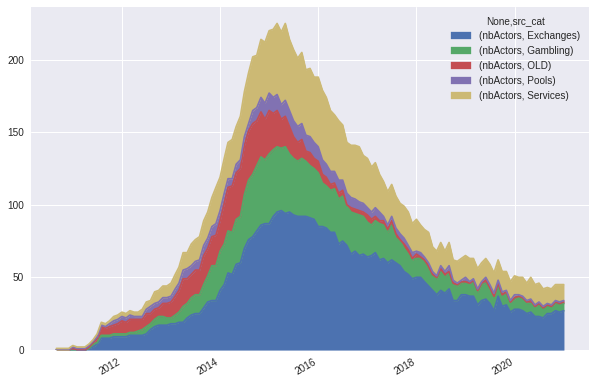

In [88]:
plt.style.use('seaborn')
to_plot.plot.area(figsize=(10,7))

# by cluster size

In [142]:
#for_clusters= with_categories
#for_clusters = with_categories.filter(col("year")==2012)

In [68]:
by_actor=data.groupBy("year","month","src_identity").agg(
    sum("value").alias("sum_satoshi"), 
    count("value").alias("count_tr"),
    sum("valueUSD").alias("sum_USD"),
    mean("PriceUSD").alias("PriceUSD"))

In [70]:
with_size_class = by_actor.withColumn("scale",when(col("count_tr") <10 , "<10")\
        .when(col("src_identity").isNull() , "no_cluster")\
      .when(col("count_tr") <100 , "<100")\
    .when(col("count_tr") <1000 , "<1000")\
    .when(col("count_tr") <10000 , "<10000")\
    .when(col("count_tr") <100000 , "<100000")\
    .when(col("count_tr") <1000000 , "<1000000")\
      .otherwise(">1M"))

In [71]:
group_by_scale = with_size_class.groupBy("year","month","scale").agg(
    sum("count_tr").alias("transaction_count"),
    sum("sum_USD").alias("sum_USD"),
    (sum("sum_satoshi")/100000000).alias("sum_BTC"))

In [72]:
pd_by_scale = group_by_scale.toPandas()

In [107]:
def plot_cumul(pd_df,category,value):
    pd_df = pd_df.set_index(pd.to_datetime(pd_df['year'].astype(str)  + pd_df['month'].astype(str), format='%Y%m'))
    pd_df = pd_df[[category,value]].pivot(columns=category)
    pd_df.columns = pd_df.columns.droplevel()
    #pd_df.reset_index(inplace=True) 
    #pd_df.columns = pd_df.columns.get_level_values(0)
    return(pd_df)

In [109]:
fig =plot_cumul(pd_by_scale,"scale","transaction_count")
fig
fig.plot.area()
#fig=write_formated_plot(fig,output_dir+"transaction_by_actor_size.html")
#fig.update_yaxes(type="log")
#fig.show()

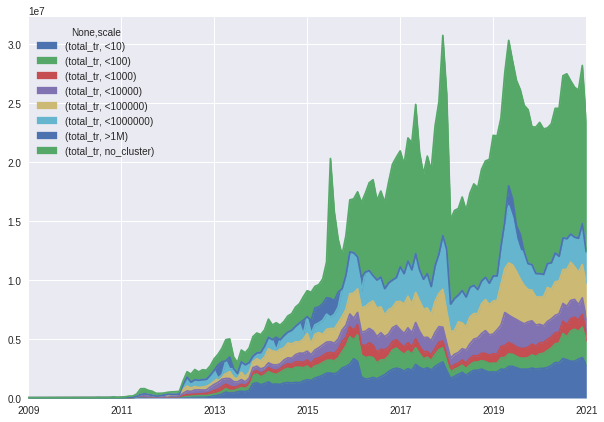

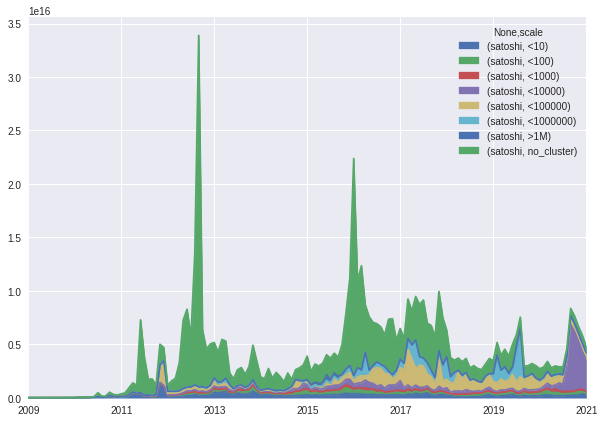

In [146]:
group_by_scale = with_size_class.groupBy("year","month","scale").agg(sum("sum_satoshi").alias("satoshi"))
plot_cumul(group_by_scale,"scale","satoshi")

In [147]:
with_size_class.filter(col("scale")=="no_cluster").show(100)

+----+-----+------------+-----------------+--------+--------------------+--------------------+----------+
|year|month|src_identity|      sum_satoshi|count_tr|             sum_dol|            PriceUSD|     scale|
+----+-----+------------+-----------------+--------+--------------------+--------------------+----------+
|2012|   10|        null| 5308413687447578|  835937|  6.23917184902435E8|  11.777014527961395|no_cluster|
|2010|    7|        null|  381055080000000|   33093|  19488.782109353146|0.061423263512276595|no_cluster|
|2010|   12|        null|  180990014418116|   22810|  445879.60845763853| 0.24743734368926232|no_cluster|
|2015|    2|        null| 1258414483425317| 2392351| 2.957301050439748E9|  235.45427747377815|no_cluster|
|2019|   10|        null|  949716879842414|13051194| 7.94073376624214E10|   8360.687866428849|no_cluster|
|2017|    3|        null| 3684476867877345|10432571|4.106699217763149E10|  1130.8196340701677|no_cluster|
|2017|    8|        null| 3676884186948964| 99

In [ ]:
df_pd[["count_tr","sum_dol","sum_btc","PriceUSD"]].plot.line(subplots=True,figsize=(10,10))

In [173]:
df.filter(~col("dst_identity").isNull()).filter(col("dst_identity").cast(IntegerType()).isNull()).show(1000)

TypeError: 'Column' object is not callable

In [15]:
df = df.withColumn("valueUSD",df["value"]/100000000*df["PriceUSD"])

In [17]:
df_2011=df.filter(col("year")==2011)

DataFrame[src: string, dst: string, value: bigint, time: int, src_identity: string, dst_identity: string, PriceUSD: float, year: int, month: int, day: int, valueUSD: double]

In [82]:
df_by_day=df.filter(col("")).groupBy("year","month","day").agg(sum("value").alias("sum_satoshi"), count("value").alias("count_tr"),sum("valueUSD").alias("sum_dol"),mean("PriceUSD").alias("PriceUSD"))

In [83]:
df_by_day.write.save("/media/ssd2/bitcoinRemy/analysis/groupBy",mode="overwrite")

In [84]:
agg = spark.read.load("/media/ssd2/bitcoinRemy/analysis/groupBy").withColumn("sum_btc",col("sum_satoshi")/100000000)

In [107]:
agg

DataFrame[year: int, month: int, day: int, sum_satoshi: bigint, count_tr: bigint, sum_dol: double, PriceUSD: double, sum_btc: double]

In [85]:
df_pd= agg.select("*").toPandas()

In [101]:
#df_pd =df_pd.set_index(pd.to_datetime(df_pd['year'].astype(str)  + df_pd['month'].astype(str), format='%Y%m'))
df_pd =df_pd.set_index(pd.to_datetime(df_pd[["year","month","day"]], format='%Y%m%d'))



In [106]:
df_pd[(df_pd["year"]==2020) & (df_pd["month"]==1)& (df_pd["day"]==4)]

,year,month,day,sum_satoshi,count_tr,sum_dol,PriceUSD,sum_btc
2020-01-04,2020,1,4,66637219229789,721726,4.893280e+09,7343.164062,666372.192298


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8cb90a5780>,
      dtype=object)

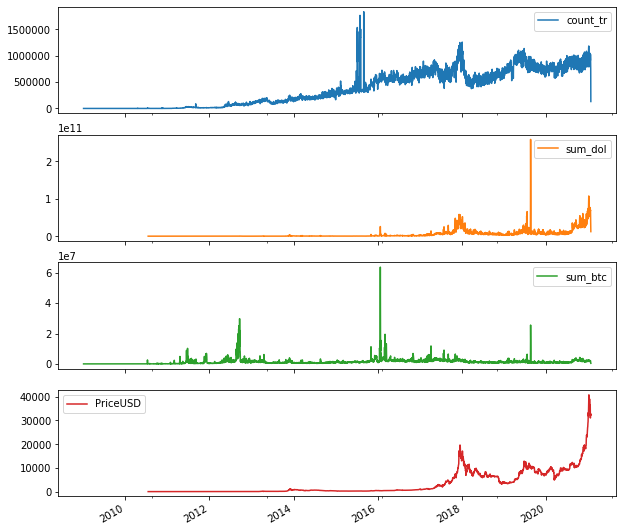

In [103]:
df_pd[["count_tr","sum_dol","sum_btc","PriceUSD"]].plot.line(subplots=True,figsize=(10,10))

In [235]:
data

DataFrame[hash: string, output_id: bigint, src: string, dst: string, value: bigint, time: string, nb_inputs: bigint, nb_outputs: bigint, fee: bigint, src_identity: string, dst_identity: string, PriceUSD: float, valueUSD: double, spent_timestamp: string, next_nb_inputs: bigint, dst_2: string, src_2: string, dst_cat: string, src_cat: string, year: int, month: int, day: int]

In [ ]:
data= spark.read.load("/media/ssd2/bitcoinRemy/tr_everything_by_day/")

In [244]:
silkRoad = data.select("year","month","src","dst","value","time","fee","src_identity","dst_identity","PriceUSD","valueUSD","dst_cat","src_cat")\
.filter((col("src_identity")=="SilkRoadMarketplace") | (col("src_identity")=="SilkRoad2Market") | (col("dst_identity")=="SilkRoadMarketplace") | (col("dst_identity")=="SilkRoad2Market"))

In [240]:
silkRoad.count()

2089628

In [245]:
silkRoad.repartition("year", "month").drop("date").write.partitionBy("year", "month").save("/media/ssd2/bitcoinRemy/silk")

In [246]:
test= spark.read.load("/media/ssd2/bitcoinRemy/silk")

In [248]:
test.coalesce(1).write.save("/media/ssd2/bitcoinRemy/silk_1_file")

In [162]:
spark.read.load("/media/ed5/remyBitcoin/whole_dataset/").filter(col("year")==2019).show(truncate=False)

+----------------------------------------------------------------+------+----------+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------+----------+----+-----+---+
|hash                                                            |bloc  |timestamp |fee        |inputs                                                                                                                                                                        